In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

sys.path.insert(0, '../libraries')
from mrcnn.config import Config
import mrcnn.utils as utils
import mrcnn.model as modellib
import mrcnn.visualize as visualize
from mrcnn.model import log
import mcoco.coco as coco
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

%matplotlib inline
%config IPCompleter.greedy=True
BASE_DIR = '/root/data/models/erko/mask_rcnn_instance_segmentation'
DATA_DIR = '/root/data/aquabyte-images/erko/'
WEIGHTS_DIR = os.path.join(BASE_DIR, "weights")
MODEL_DIR = os.path.join(BASE_DIR, "logs")

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


### #0. Get the datasets ready

In [2]:
from pycocotools.coco import COCO
import json

In [3]:
dataset_train  = coco.CocoDataset()
dataset_train.load_coco('/root/data/aquabyte-images/cocofiles/coco_clear_full_curved_2018-09-07.json', class_ids=[0])
dataset_train.load_coco('/root/data/aquabyte-images/cocofiles/coco_clear_full_curved_2018-09-08.json', class_ids=[0])
# dataset_train.load_coco('/root/data/aquabyte-images/cocofiles/coco_clear_full_curved_2018-09-10.json', class_ids=[0])
# dataset_train.load_coco('/root/data/aquabyte-images/cocofiles/coco_clear_full_curved_2018-09-11.json', class_ids=[0])
dataset_train.prepare()

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


### #1. Config

In [4]:
image_size = 1024
rpn_anchor_template = (1, 2, 4, 8, 16) # anchor sizes in pixels
rpn_anchor_scales = tuple(i * (image_size // 16) for i in rpn_anchor_template)

class FishConfig(Config):
    """Configuration for training on the shapes dataset.
    """
    NAME = "shapes"

    # Train on 1 GPU and 2 images per GPU. Put multiple images on each
    # GPU if the images are small. Batch size is 2 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes (triangles, circles, and squares)

    # Use smaller images for faster training. 
    IMAGE_MAX_DIM = image_size
    IMAGE_MIN_DIM = image_size
    
    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = rpn_anchor_scales

    # Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    STEPS_PER_EPOCH = 400

    VALIDATION_STEPS = STEPS_PER_EPOCH / 20
    USE_MINI_MASK= False
config = FishConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_mask_loss': 1.0, 'mrcnn_class_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'rpn_bbox_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.

### #2. Data generator

In [5]:
import imgaug
from imgaug import augmenters as iaa
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [6]:
from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomContrast,
    RandomGamma,
    RandomBrightness
)

In [7]:
augmentation = {'albumentations': [
    OneOf([RandomSizedCrop(min_max_height=(50, 101), height=512, width=512, p=0.5),
          PadIfNeeded(min_height=512, min_width=512, p=0.5)], p=1),    
    VerticalFlip(p=0.5),              
    RandomRotate90(p=0.5),
    OneOf([
        ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        GridDistortion(p=0.5),
        OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
        ], p=0.8),
    CLAHE(p=0.8),
    RandomContrast(p=0.8),
    RandomBrightness(p=0.8),
    RandomGamma(p=0.8)], 'imgaug': None}

## 1 - Contrast

Without

In [8]:
augmentation = {'albumentations': [   
    RandomContrast(p=0.0),
    CLAHE(p=0.0),
], 'imgaug': None}

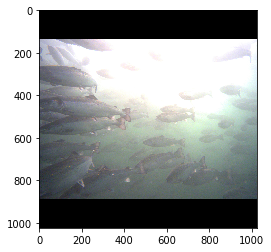

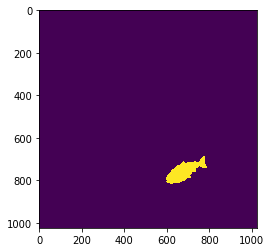

In [9]:
image, image_meta, gt_class_ids, gt_boxes, gt_masks = modellib.load_image_gt(dataset_train, config, 1, \
                  augmentation=augmentation, use_mini_mask=config.USE_MINI_MASK)
plt.imshow(image)
plt.show()
plt.imshow(gt_masks.squeeze())
plt.show()

With 

In [10]:
augmentation = {'albumentations': [   
    RandomContrast(p=0.6),
    CLAHE(p=0.6),
], 'imgaug': None}

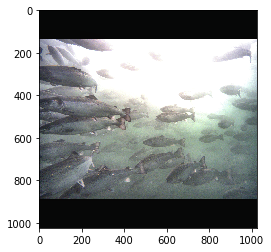

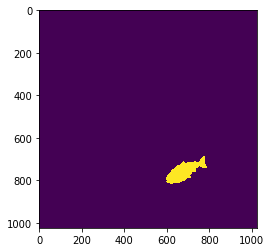

In [11]:
image, image_meta, gt_class_ids, gt_boxes, gt_masks = modellib.load_image_gt(dataset_train, config, 1, \
                  augmentation=augmentation, use_mini_mask=config.USE_MINI_MASK)
plt.imshow(image)
plt.show()
plt.imshow(gt_masks.squeeze())
plt.show()

## 2 - Random crops

In [22]:
augmentation = {'albumentations': [   
    OneOf([RandomSizedCrop(min_max_height=(300, 300), height=1024, width=1024, p=1.0),
          PadIfNeeded(min_height=1024, min_width=1024, p=0.5)], p=1.0)], 'imgaug': None}

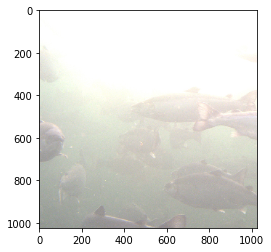

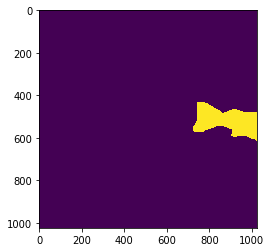

In [23]:
image, image_meta, gt_class_ids, gt_boxes, gt_masks = modellib.load_image_gt(dataset_train, config, 30, \
                  augmentation=augmentation, use_mini_mask=config.USE_MINI_MASK)
plt.imshow(image)
plt.show()
plt.imshow(gt_masks[..., 0])
plt.show()

## 3 - Brightness

In [200]:
augmentation = {'albumentations': [   
   RandomBrightness(p=1.0),
    RandomGamma(p=1.0)], 'imgaug': None}

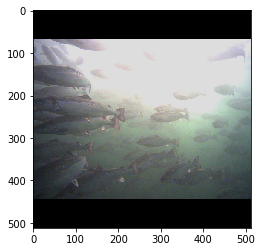

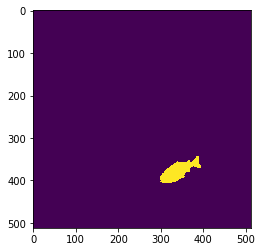

In [201]:
image, image_meta, gt_class_ids, gt_boxes, gt_masks = modellib.load_image_gt(dataset_train, config, 1, \
                  augmentation=augmentation, use_mini_mask=config.USE_MINI_MASK)
plt.imshow(image)
plt.show()
plt.imshow(gt_masks[..., 0])
plt.show()

In [222]:
augmentation = {'albumentations': [   
   OneOf([
        OpticalDistortion(p=1, distort_limit=0.6, shift_limit=0.2)                  
        ], p=1),], 'imgaug': None}

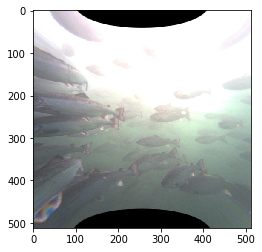

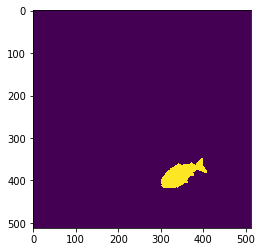

In [223]:
image, image_meta, gt_class_ids, gt_boxes, gt_masks = modellib.load_image_gt(dataset_train, config, 1, \
                  augmentation=augmentation, use_mini_mask=config.USE_MINI_MASK)
plt.imshow(image)
plt.show()
plt.imshow(gt_masks[..., 0])
plt.show()

Since datas are rectified, not really relevant. We will start with basic things

In [ ]:
augmentation = {'albumentations': [
    OneOf([RandomSizedCrop(min_max_height=(300, 300), height=1024, width=1024, p=0.5),
          PadIfNeeded(min_height=1024, min_width=1024, p=0.5)], p=1),
    CLAHE(p=0.6),
    RandomContrast(p=0.6),
    RandomBrightness(p=0.8),
    RandomGamma(p=0.8)], 'imgaug': None}